In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(img)
    plt.show()

# 轮廓信息
使用统计方法从已知形状轮廓的矩<sup>[1]</sup>中提取信息.

[1]: [图像矩-维基百科](https://zh.wikipedia.org/wiki/%E7%9F%A9_(%E5%9B%BE%E5%83%8F))

例如如下的倾斜矩形图案, 获取它的轮廓并计算轮廓的矩:

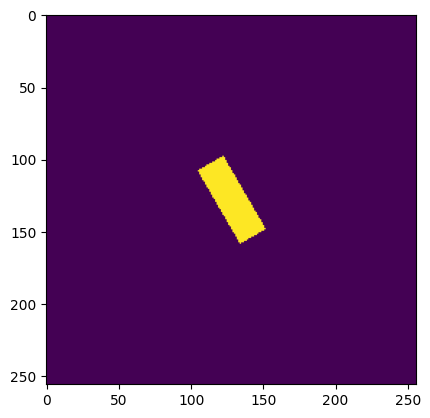

In [2]:
l = 60
w = 20
theta = np.pi/3
size = 256

target = np.zeros((size,size,1), np.uint8)
c = size//2
dlx =  l/2*np.cos(theta)
dly =  l/2*np.sin(theta)
dwx = -w/2*np.sin(theta)
dwy =  w/2*np.cos(theta)
rect = np.array([[ dlx+dwx,  dly+dwy],
                 [ dlx-dwx,  dly-dwy],
                 [-dlx-dwx, -dly-dwy],
                 [-dlx+dwx, -dly+dwy]]).astype(np.int32) + c
cv.fillPoly(target, [rect], (255))
imshow(target)

In [3]:
cnt = cv.findContours(target, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0][0]
m = cv.moments(cnt)
m

{'m00': 1140.0,
 'm10': 145911.5,
 'm01': 145925.0,
 'm20': 18783239.5,
 'm11': 18799064.666666664,
 'm02': 18925803.333333332,
 'm30': 2431674583.75,
 'm21': 2435505618.9166665,
 'm12': 2453532032.25,
 'm03': 2485756287.5,
 'mu20': 107655.4366228059,
 'mu11': 121752.70394736528,
 'mu02': 246763.31140350923,
 'mu30': 1791.8326077461243,
 'mu21': 1703.6872523128986,
 'mu12': 558.8125392459333,
 'mu03': -3119.385772228241,
 'nu20': 0.08283736274454132,
 'nu11': 0.09368475219095514,
 'nu02': 0.1898763553428049,
 'nu30': 4.083525832296725e-05,
 'nu21': 3.882645552323858e-05,
 'nu12': 1.273514852647112e-05,
 'nu03': -7.108974536307627e-05}

其中 **0 阶原点矩**(`m00`) 为轮廓的面积, 两个 **1 阶原始矩**(`m10`, `m01`) 与 $x$, $y$ 方向点分布的期望有关.
具体地说, $\frac{m_{10}}{m_{00}}$, $\frac{m_{01}}{m_{00}}$ 分别为 $x$, $y$ 方向的数学期望, 或均值, 即轮廓的质心所在.

In [4]:
centroid = np.array([m['m01']/m['m00'], m['m10']/m['m00']])

print(f"centroid:\ncalc={centroid}\ntrue={np.array([size/2, size/2])}")

centroid:
calc=[128.00438596 127.99254386]
true=[128. 128.]


我们更关心轮廓的 **中心矩**, 它相当于将轮廓质心平移到原点后计算的原始矩.
因此无论轮廓在图上什么位置, 中心矩始终保持不变. 这就是中心矩的 _平移不变性_.

图案的 **2 阶中心矩** 与方差有关. 三个 2 阶中心矩除面积即为方差: $\frac{\mu_{20}}{m_{00}}$, $\frac{\mu_{02}}{m_{00}}$, $\frac{\mu_{11}}{m_{00}}$ 分别为 $\mathrm{Var}{(X)}$, $\mathrm{Var}{(Y)}$ 与协方差 $\mathrm{Cov}{(X,Y)}$.

通过构建协方差矩阵:
$$
\begin{align*}
\mathbf{cov}{(X,Y)} & =
\begin{pmatrix}
\mathrm{Var}{(X)}   & \mathrm{Cov}{(X,Y)} \\
\mathrm{Cov}{(X,Y)} & \mathrm{Var}{(X)}
\end{pmatrix} \\
& = \frac{1}{m_{00}}
\begin{pmatrix}
\mu_{20} & \mu_{11} \\
\mu_{11} & \mu_{02}
\end{pmatrix}
\end{align*}
$$
求解其特征向量, 便可得到其主方向与副方向, 也就是方差最大与最小的方向.
具体到矩形区域上, 特征值较大的特征向量对应矩形的长轴 (长), 较小的对应矩形的短轴 (宽).

进一步可以知道, 特征值是 在对应的特征向量方向上图案的方差.
因为特征向量恰好是矩形的长轴与短轴方向, 因此在这个方向上的方差是一个 _均匀分布_ 的方差.
对于均匀分布, 其方差只与分布长度有关. 方差 $\sigma^2$ 有
$$
\sigma^2 = \frac{l^2}{12}
$$
其中 $l$ 是分布区间长度. 这样我们就可以通过特征值分解协方差矩阵, 得到矩形的方向与长度信息.

对于二阶矩阵, 容易计算其特征值与特征向量:

$$
\lambda_1 = \frac{1}{2 m_{00}} (-\sqrt{(\mu_{02}-\mu_{20})^2+4 \mu_{11}^2}+\mu_{02}+\mu_{20}) \\
~\\
\mathbf{v}_1 = (\frac{-\sqrt{(\mu_{02}-\mu_{20})^2+4 \mu_{11}^2}-\mu_{02}+\mu_{20}}{2 \mu_{11}}, 1)^T
$$

$$
\lambda_2 = \frac{1}{2 m_{00}} (\sqrt{(\mu_{02}-\mu_{20})^2+4 \mu_{11}^2}+\mu_{02}+\mu_{20}) \\
~\\
\mathbf{v}_2 = (\frac{\sqrt{(\mu_{02}-\mu_{20})^2+4 \mu_{11}^2}-\mu_{02}+\mu_{20}}{2 \mu_{11}}, 1)^T
$$

根据特征向量 $\mathbf{v}_2$ 可以计算出矩形的方向.

In [5]:
delta = (m['mu02']-m['mu20'])**2 + 4*m['mu11']**2
v2 = np.array([(np.sqrt(delta) - m['mu02'] + m['mu20'])/(2*m['mu11']), 1])
phi = np.atan(v2[1]/v2[0])

print(f"theta:\ncalc={np.rad2deg(np.fmod(phi+2*np.pi, 2*np.pi)):.4}°\ntrue={np.rad2deg(np.fmod(theta+2*np.pi, 2*np.pi)):.4}°")

theta:
calc=59.87°
true=60.0°


显然 $\lambda_1 < \lambda_2$, 则其长轴长为 $\sqrt{12 \lambda_2}$, 短轴长为 $\sqrt{12 \lambda_1}$.

In [6]:
lambda1 = (m['mu02']+m['mu20']-np.sqrt(delta))/(2*m['m00'])
lambda2 = (m['mu02']+m['mu20']+np.sqrt(delta))/(2*m['m00'])

print(f"width:\ncalc={np.sqrt(12*lambda1):.4f}\ntrue={w}")
print()
print(f"length:\ncalc={np.sqrt(12*lambda2):.4f}\ntrue={l}")

width:
calc=19.7324
true=20

length:
calc=57.8045
true=60


另外, 只需将特征向量旋转 $90\degree$ 即可. 使用预定义的旋转矩阵可以很方便地完成.

In [7]:
# 演示旋转矩阵
R = np.array([[0, -1],
              [1,  0]])
v = np.array([1, 2])

print(f" v={v}\nRv={R@v}")

 v=[1 2]
Rv=[-2  1]


## Example

In [8]:
def contour_info(cnt: np.ndarray) -> tuple[np.ndarray, np.ndarray, float, float, float]:
    """计算轮廓的诸特征

    Args:
        cnt (np.ndarray): 轮廓, 由 `cv2.findContours` 得到.

    Returns:
        返回一个元组 `(position, offset, angle, length, width)`, 分别代表
        (**质心坐标,即位置**; **极点偏移量**; **角度[弧度制]**; **长度**; **宽度**).
        
        其中 **极点偏移量** `offset` 为 质心 到 矩形窄边中点 的向量.
        那么 `position+offset` 与 `position-offset` 就代表了矩形窄边中点的位置.
    """
    
    m = cv.moments(cnt)
    
    delta_root = np.sqrt(4*m['mu11']**2 + (m['mu20']-m['mu02'])**2)
    A = 2*m['mu11']/(m['mu20']-m['mu02']+delta_root)
    
    if np.isnan(A):
        x = 0
        y = 1
    else:
        x = 1/np.sqrt(A*A+1)
        y = A*x
    
    # 主轴方向的方差
    var_pri = 0.5*(m['mu20']+m['mu02']+delta_root)/m['m00']
    # 主轴长度的一半
    len_half_pri = np.sqrt(3*var_pri)
    
    # 副轴方向的方差
    var_sec = 0.5*(m['mu20']+m['mu02']-delta_root)/m['m00']
    # 副轴长度的一半
    len_half_sec = np.sqrt(3*var_sec)
    
    # 主轴方向
    # 已经过归一化
    dir_v = np.array([x, y])
    # 副轴方向
    # 直接将主轴旋转 90 deg 而来
    #dir_sec_v = np.array([[0, -1],
    #                      [1,  0]])@dir_v
    # 质心坐标
    pos_v = np.array([m['m10']/m['m00'], m['m01']/m['m00']])
    
    return (pos_v,
            len_half_pri*dir_v,
            np.atan(A),
            2*len_half_pri,
            2*len_half_sec)

In [9]:
contour_info(cnt)

(array([127.99254386, 128.00438596]),
 array([14.5082767 , 24.99697385]),
 np.float64(1.04491228382786),
 np.float64(57.80445638257416),
 np.float64(19.73242219672937))